In [3]:
import json
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Faulty engine", 'Fixed by', "Code Size"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    table_data.append([
        test_name,
        metadata['engine'],
        metadata['fixed-by'],
        data['metadata']['code-size'],
        # metadata['function_count']
    ])
# Sort the table data by the original size code
table_data.sort(key=lambda row: row[3] if isinstance(row[3], (int, float)) else float('inf'))

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, intfmt=",", tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
print(f"Number of eval set: {len(table_data)}")
rq1_table_path = f'./table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    print(latex_table)
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

Number of eval set: 28
\begin{tabular}{lllr}
\hline
 Name            & Faulty engine   & Fixed by   &   Code Size \\
\hline
 wasmedge\#3018   & WasmEdge        & 93fd4ae    &       1,913 \\
 wamr\#2789       & Wamr            & 718f06     &      17,604 \\
 wasmedge\#3019   & WasmEdge        & 93fd4ae    &      19,098 \\
 wamr\#2862       & Wamr            & 0ee5ff     &      19,727 \\
 wamr\#2450       & Wamr            & e360b7     &      24,482 \\
 wasmedge\#3076   & WasmEdge        & 93fd4ae    &      31,365 \\
 mandelbrot      & Wizard          & 0b43b8     &      64,515 \\
 pathfinding     & Wizard          & ccf0c56    &     180,026 \\
 pacalc          & Wizard          & 81555ab    &     238,902 \\
 wasmedge\#3057   & WasmEdge        & 93fd4ae    &     243,564 \\
 guiicons        & Wizard          & 6d2b057    &     285,840 \\
 rtexviewer      & Wizard          & 708ea77    &     296,617 \\
 rfxgen          & Wizard          & 6d2b057    &     378,918 \\
 riconpacker     & Wizar

In [7]:
import json
import tabulate
from scipy.stats import gmean

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Code Size",  "RR-Reduce Code Size (Target Size)", "wasm-reduce Code Size", "wasm-hybrid Code Size"]

# size_to_use = 'module-size'
size_to_use = 'code-size'

lowest_tool = {}
for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        fixed_by = metadata.get('fixed-by')
        wrong_code = metadata.get('wrong-code')
        original_code_size = data['metadata'].get(size_to_use)
        rr_reduce_code_size = data['wasm-slice'].get('code-size')
        rr_reduce_target_size = data['wasm-slice'].get('target-size')
        wasm_hybrid_all_code_size = data['wasm-hybrid-all'].get(size_to_use)
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)

        rr_reduce_code_size_percentage = (rr_reduce_code_size / original_code_size) * 100
        rr_reduce_target_size_percentage = (rr_reduce_target_size / original_code_size) * 100
        wasm_hybrid_all_code_size_percentage = (wasm_hybrid_all_code_size / original_code_size) * 100
        wasm_reduce_code_size_percentage = (wasm_reduce_code_size / original_code_size) * 100
        # Determine the tool with the lowest code size percentage
        min_percentage = min(rr_reduce_code_size_percentage, wasm_reduce_code_size_percentage, wasm_hybrid_all_code_size_percentage)
        lowest_tools = []
        if min_percentage == rr_reduce_code_size_percentage:
            lowest_tools.append('RR-Reduce Code Size')
        if min_percentage == wasm_reduce_code_size_percentage:
            lowest_tools.append('wasm-reduce Code Size')
        if min_percentage == wasm_hybrid_all_code_size_percentage:
            lowest_tools.append('wasm-hybrid Code Size')
        lowest_tool[test_name] = ', '.join(lowest_tools)

        table_data.append([
            test_name,
            original_code_size,
            f"{rr_reduce_code_size_percentage:.4f}% ({rr_reduce_target_size_percentage:.4f}%)",
            f"{wasm_reduce_code_size_percentage:.4f}%",
            f"{wasm_hybrid_all_code_size_percentage:.4f}%"
        ])
    except Exception as e:
        print(test_name, data)
        print(e)
        continue
# Sort the table data by the original size
table_data.sort(key=lambda row: float(row[1]))

# Calculate geometric mean for the percentages
geomean_rr_reduce = gmean([float(row[2].split('%')[0]) for row in table_data if row[2] != ""])
geomean_rr_reduce_target = gmean([float(row[2].split('(')[1].split('%')[0]) for row in table_data if '(' in row[2]])
geomean_wasm_hybrid_all = gmean([float(row[4].split('%')[0]) for row in table_data if row[4] != ""])
geomean_wasm_reduce = gmean([float(row[3].split('%')[0]) for row in table_data if row[3] != ""])

# Append the geometric mean row
table_data.append([
    "Geomean",
    "",
    f"{geomean_rr_reduce:.4f}% ({geomean_rr_reduce_target:.4f}%)",
    f"{geomean_wasm_reduce:.4f}%",
    f"{geomean_wasm_hybrid_all:.4f}%"
])

# Add geometric mean to lowest_tool
lowest_tool["Geomean"] = "wasm-hybrid Code Size"

# Make the lowest tool bold in the table
for row in table_data:
    test_name = row[0]
    if test_name in lowest_tool:
        tools = lowest_tool[test_name]
        for tool in tools.split(', '):
            tool_index = headers.index(tool)
            row[tool_index] = f"\\textbf{{{row[tool_index]}}}"

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=".f")

# Escape percentage signs in the LaTeX table
latex_table = latex_table.replace('%', '\\%')

rq2_table_path = f'./table/rq1.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{lllll}
\hline
 Name            & Input Code Size   & RR-Reduce Code Size (Target Size)   & wasm-reduce Code Size   & wasm-hybrid Code Size   \\
\hline
 wasmedge#3018   & 1913              & 23.7324\% (17.0936\%)                 & 1.2546\%                 & \textbf{0.5750\%}        \\
 wamr#2789       & 17604             & 1.9087\% (0.1761\%)                   & \textbf{0.0511\%}        & \textbf{0.0511\%}        \\
 wasmedge#3019   & 19098             & 3.7491\% (0.9163\%)                   & \textbf{0.0628\%}        & \textbf{0.0628\%}        \\
 wamr#2862       & 19727             & 9.2716\% (7.1171\%)                   & \textbf{0.1825\%}        & \textbf{0.1825\%}        \\
 wamr#2450       & 24482             & 4.3338\% (1.8748\%)                   & \textbf{0.0327\%}        & \textbf{0.0327\%}        \\
 wasmedge#3076   & 31365             & 2.8121\% (0.3316\%)                   & \textbf{0.0574\%}        & \textbf{0.0574\%}        \\
 mandelbrot      & 64515     

In [3]:
import json
from scipy.stats import gmean
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input", "RR-R (s)", "RR-H (s)","W-R (s)"]

for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        # fixed_by = metadata.get('fixed-by')
        original_size = data['metadata'].get('code-size')
        rr_reduce_time = float(data['wasm-slice'].get('time'))
        wasm_hybrid_all_time = float(data['wasm-hybrid-all'].get('time')) + rr_reduce_time
        wasm_reduce_time = float(data['wasm-reduce'].get('time'))
        table_data.append([
            test_name,
            # fixed_by,
            original_size,
            rr_reduce_time,
            wasm_hybrid_all_time,
            wasm_reduce_time
        ])
    except Exception as e:
        print(e)
        continue

# Sort the table data by the original size
table_data.sort(key=lambda row: float(row[1]))

# Calculate geometric mean for the times
geomean_rr_reduce_time = gmean([row[2] for row in table_data])
geomean_wasm_hybrid_all_time = gmean([row[3] for row in table_data])
geomean_wasm_reduce_time = gmean([row[4] for row in table_data])

# Append the geometric mean row
table_data.append([
    "Geomean",
    "",
    geomean_rr_reduce_time,
    geomean_wasm_hybrid_all_time,
    geomean_wasm_reduce_time
])

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=",.0f")

rq2_table_path = f'./table/rq2.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{llrrr}
\hline
 Name            & Input   &   RR-R (s) &   RR-H (s) &   W-R (s) \\
\hline
 wasmedge#3018   & 1913    &        120 &        131 &        15 \\
 wamr#2789       & 17604   &        245 &        254 &       195 \\
 wasmedge#3019   & 19098   &        121 &        134 &       329 \\
 wamr#2862       & 19727   &        182 &        215 &        42 \\
 wamr#2450       & 24482   &         14 &         25 &        29 \\
 wasmedge#3076   & 31365   &        203 &        203 &       537 \\
 mandelbrot      & 64515   &        137 &     86,537 &    71,808 \\
 pathfinding     & 180026  &      1,246 &      1,760 &    12,057 \\
 pacalc          & 238902  &         21 &     13,181 &     8,196 \\
 wasmedge#3057   & 243564  &        121 &        137 &     1,193 \\
 guiicons        & 285840  &         38 &      8,537 &    33,682 \\
 rtexviewer      & 296617  &        561 &        686 &       216 \\
 rfxgen          & 378918  &         55 &     12,569 &    12,548 \\
 riconpacke

Wasm Reduce Sizes: [5, 5, 8, 9, 12, 12, 18, 24, 36, 174, 479, 499, 1023, 3438, 4267, 4654, 18412, 32967, 33198, 33541, 33946, 34002, 34660, 76827, 310331, 317816, 363523, 1577758]
Wasm Slice Target Sizes: [6, 10, 31, 104, 175, 209, 277, 327, 424, 459, 782, 1404, 1655, 2136, 6088, 6762, 10354, 22234, 33851, 48862, 106812, 114484, 120092, 142554, 144615, 157996, 170880, 536115]
Wasm Slice Sizes: [336, 454, 716, 882, 1061, 1202, 1829, 6134, 10194, 16181, 18651, 25613, 28558, 33037, 34808, 52744, 56136, 61097, 70776, 83434, 119321, 170002, 172650, 205267, 262206, 275255, 279821, 536115]
Wasm Hybrid All Sizes: [5, 5, 8, 9, 11, 11, 12, 18, 36, 45, 48, 49, 54, 713, 894, 1329, 2088, 10858, 32801, 32972, 32978, 33062, 33063, 35613, 35869, 36204, 59162, 363523]


/tmp/ipykernel_722106/41179209.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wasm_slice_sizes, wasm_slice_target_sizes, wasm_reduce_sizes, wasm_hybrid_all_sizes],


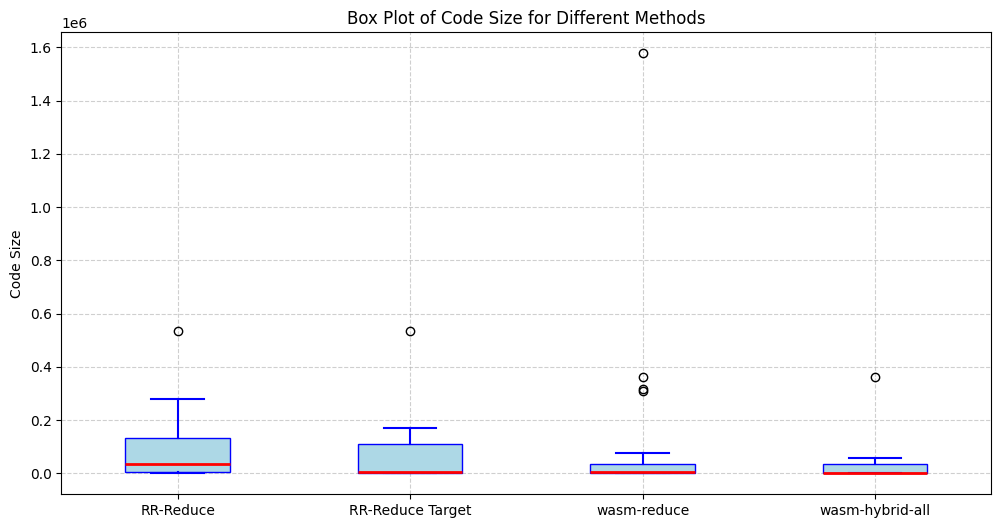

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# size_to_use = "module-size"
size_to_use = "code-size"

# Collecting code size data
wasm_reduce_sizes = []
wasm_slice_target_sizes = []
wasm_slice_sizes = []
wasm_hybrid_all_sizes = []

test_names = []

for test_name, data in metrics.items():
    try:
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)
        wasm_slice_target_size = data['wasm-slice'].get('target-size')
        wasm_slice_code_size = data['wasm-slice'].get(size_to_use)
        wasm_hybrid_all_code_size = data['wasm-hybrid-all'].get(size_to_use)

        if wasm_reduce_code_size is not None and wasm_slice_target_size is not None and  wasm_slice_code_size is not None and wasm_hybrid_all_code_size is not None:
            test_names.append(test_name)
            wasm_reduce_sizes.append(wasm_reduce_code_size)
            wasm_slice_target_sizes.append(wasm_slice_target_size)
            wasm_slice_sizes.append(wasm_slice_code_size)
            wasm_hybrid_all_sizes.append(wasm_hybrid_all_code_size)
    except Exception as e:
        print(f"Error processing {test_name}: {e}")

# Ensure we have valid numerical data
wasm_reduce_sizes = sorted(wasm_reduce_sizes)
wasm_slice_target_sizes = sorted(wasm_slice_target_sizes)
wasm_slice_sizes = sorted(wasm_slice_sizes)
wasm_hybrid_all_sizes = sorted(wasm_hybrid_all_sizes)
print("Wasm Reduce Sizes:", wasm_reduce_sizes)
print("Wasm Slice Target Sizes:", wasm_slice_target_sizes)
print("Wasm Slice Sizes:", wasm_slice_sizes)
print("Wasm Hybrid All Sizes:", wasm_hybrid_all_sizes)
plt.figure(figsize=(12, 6))

# Create box plots side by side
plt.boxplot([wasm_slice_sizes, wasm_slice_target_sizes, wasm_reduce_sizes, wasm_hybrid_all_sizes],
            vert=True, patch_artist=True,
            labels=['RR-Reduce', 'RR-Reduce Target', "wasm-reduce", "wasm-hybrid-all"],
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue', linewidth=1.5),
            capprops=dict(color='blue', linewidth=1.5))

plt.ylabel("Code Size")
plt.title("Box Plot of Code Size for Different Methods")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()